In [ ]:
%tensorflow_version 1.14

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.14`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [ ]:
import tensorflow as tf

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals


import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [ ]:
import nibabel as nib
segmented_img = nib.load("/content/drive/My Drive/Tumor_segmentation/Brats18_2013_11_1_seg.nii.gz")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
segmented_img_array = segmented_img.get_fdata()

In [ ]:
import numpy as np
np.max(segmented_img_array)

4.0

In [ ]:
t1_img = nib.load("/content/drive/My Drive/Tumor_segmentation/Brats18_2013_11_1_t1ce.nii.gz")

In [ ]:
t1_img_array = t1_img.get_fdata()

In [ ]:
np.max(t1_img_array)

211.0

In [ ]:
segmented_img_array = (segmented_img_array / np.max(segmented_img_array)) * 255

In [ ]:
t1_img_array = (t1_img_array / np.max(t1_img_array)) * 255

In [ ]:
print(np.average(segmented_img_array))
print(np.average(t1_img_array))

1.942411374327957
10.440664940376093


In [ ]:
segmented_img_array.shape

(240, 240, 155)

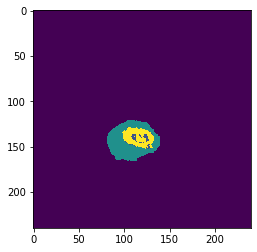

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(segmented_img_array[:,:, 100], interpolation='nearest')
plt.show()

In [ ]:
training_data = []
for i in range(0, 155, 1):
    
    training_data.append(t1_img_array[:,:,i])

In [ ]:
labels = []
for i in range(0, 155, 1):
    
    labels.append(segmented_img_array[:,:,i])

In [ ]:
import numpy as np
import cv2 
for i in range(0, len(training_data),1):
    training_data[i] = cv2.resize(training_data[i], (256,256))
    #training_data[i] = np.stack((training_data[i],)*3, axis=-1)
    labels[i] = cv2.resize(labels[i], (256,256), interpolation = cv2.INTER_AREA)
    #labels[i] = np.stack((labels[i],)*3, axis=-1)

In [ ]:
labels[2].shape

(256, 256)

In [ ]:
labels[4].shape
for i in range(len(labels)):
  for j in range(256):
    for k in range(256):
      if(labels[i][j,k]>=1):
        labels[i][j,k] = 1
      else:
        labels[i][j,k] = 0

In [ ]:
import numpy as np
X = np.array(training_data).reshape(-1, 256,256, 1)
Y = np.array(labels).reshape(-1, 256,256, 1)
X = X/255.

In [ ]:
np.average(Y)

0.01643834267893145

In [ ]:

index = 100
initial = np.copy(X[index])
img = np.copy(X[index])
img = img*255

    
import matplotlib.pyplot as plt
plt.imshow(img.astype(np.uint8))

In [ ]:
np.average(Y)

0.01643834267893145

In [ ]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras


def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model


Using TensorFlow backend.


In [ ]:
model = unet()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [ ]:
model.fit(X, Y, validation_split=0.3, epochs=10, batch_size=20)

In [ ]:
X[100].shape

In [ ]:
prediction = model.predict(X)

In [ ]:
prediction.shape

In [ ]:
prediction[10].shape

In [ ]:
prediction = np.squeeze(prediction)

In [ ]:
prediction.shape

In [ ]:
map_data = []
for i in range(0, len(prediction),1):
  map_data.append(np.stack((prediction[i],)*3, axis=-1))

In [ ]:
index = 60
initial = np.copy(map_data[index])
img = np.copy(map_data[index])
img = img*255

    
import matplotlib.pyplot as plt
plt.imshow(img.astype(np.uint8))

In [ ]:
y_squeezed = np.squeeze(Y)
img= (np.stack((y_squeezed[60],)*3, axis=-1))

In [ ]:
img = img*255

    
import matplotlib.pyplot as plt
plt.imshow(img.astype(np.uint8))